# CLUSTERING SMART CITIES AROUND THE WORLD BASED ON THEIR VENUES 
- by Bhaskar Rao

In [1]:
#Import Packages
from bs4 import BeautifulSoup
import requests

import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import datetime
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
import requests 
from pandas.io.json import json_normalize 

from geopy.geocoders import Nominatim 
import geopy
import geopandas

import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [2]:
# Function to get categories from venues
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [4]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
#Put into pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Web scrape Smart Cities Data 
<a href = "https://www.smartcitygovt.com/">Link for Smart Cities</a>

In [6]:
# Web Extract data from wikipedia
# looking at smart cities provided by government
website_url = requests.get("https://www.smartcitygovt.com/").text
soup = BeautifulSoup(website_url,"lxml")
#My_table = soup.find("table",{"class":"tg"})
My_table = soup.find("table",id = "tg-UjFm6")
#My_table = soup.find("table","tg-UjFm6") 
My_table
table_data = My_table.find_all("tr")
column = [x.text.strip() for x in table_data[0].find_all("th")]
column
table_data[1]
data_table = pd.DataFrame(columns = column)
#Create basic data table - Top 10 cities
rows = []
for i in range(51):
    try:
        rows = [x.text.strip() for x in table_data[i].find_all("td")]
        data_table.loc[i] = rows
    except:
        next
    next

data_table

,Ranking,City,Total Score,Vision,Leadership,Budget,Financial Incentives,Support Programmes,Talent-Readiness,People Centricity,Innovation Ecosystem,Smart Policies,Track Record
1,1,London,33.5,3.1,4,3,4,3,3.1,3,4.1,3.1,3.1
2,2,Singapore,32.3,3,4,3,4.1,3,3.1,2,3.1,4,3
3,3,Seoul,31.4,3.1,3,3,2.2,3,3,4.1,3,3,4
4,4,New York,31.3,3,3,3,3.1,3,3.1,3,4,2,4.1
5,5,Helsinki,31.2,3,2,4,3.1,3,4,3,3.1,2,4
6,6,Montreal,30.1,3.1,3,3,4,3,2,3,3,3,3
7,7,Boston,29.6,3,3,3,2.1,3,3.1,3.1,3.1,3.1,3.1
8,8,Melbourne,29.5,3,3,3,2.1,3.1,3.1,4,3.2,2,3
9,9,Barcelona,29.4,3,3,3,2.1,2,3.1,3,3.1,3.1,4
10,10,Shanghai,29.2,3,3,4,3.1,3,2,2,3,2.1,4


In [7]:
data_table.dtypes

Ranking                 object
City                    object
Total Score             object
Vision                  object
Leadership              object
Budget                  object
Financial Incentives    object
Support Programmes      object
Talent-Readiness        object
People Centricity       object
Innovation Ecosystem    object
Smart Policies          object
Track Record            object
dtype: object

In [8]:
data_table["Ranking"] = pd.to_numeric(data_table["Ranking"])
data_table["Total Score"] = pd.to_numeric(data_table["Total Score"])
data_table["Vision"] = pd.to_numeric(data_table["Vision"])
data_table["Leadership"] = pd.to_numeric(data_table["Leadership"])
data_table["Budget"] = pd.to_numeric(data_table["Budget"])
data_table["Financial Incentives"] = pd.to_numeric(data_table["Financial Incentives"])
data_table["Support Programmes"] = pd.to_numeric(data_table["Support Programmes"])
data_table["Talent-Readiness"] = pd.to_numeric(data_table["Talent-Readiness"])
data_table["People Centricity"] = pd.to_numeric(data_table["People Centricity"])
data_table["Innovation Ecosystem"] = pd.to_numeric(data_table["Innovation Ecosystem"])
data_table["Smart Policies"] = pd.to_numeric(data_table["Smart Policies"])
data_table["Track Record"] = pd.to_numeric(data_table["Track Record"])

In [9]:
data_table.dtypes

Ranking                   int64
City                     object
Total Score             float64
Vision                  float64
Leadership              float64
Budget                  float64
Financial Incentives    float64
Support Programmes      float64
Talent-Readiness        float64
People Centricity       float64
Innovation Ecosystem    float64
Smart Policies          float64
Track Record            float64
dtype: object

### Add the coordinates to the smart cities using the Geopy Package

In [10]:
for i in range(len(data_table)):
    try:
        address = data_table.loc[i,"City"]
        geolocator = geopy.Nominatim(user_agent="google", timeout=30)
        location = geolocator.geocode(address)
        data_table.loc[i,"Latitude"] = location.latitude
        data_table.loc[i,"Longitude"] = location.longitude
    except:
        next
    next
    
data_table.head()

,Ranking,City,Total Score,Vision,Leadership,Budget,Financial Incentives,Support Programmes,Talent-Readiness,People Centricity,Innovation Ecosystem,Smart Policies,Track Record,Latitude,Longitude
1,1,London,33.5,3.1,4.0,3.0,4.0,3.0,3.1,3.0,4.1,3.1,3.1,51.507322,-0.127647
2,2,Singapore,32.3,3.0,4.0,3.0,4.1,3.0,3.1,2.0,3.1,4.0,3.0,1.357107,103.819499
3,3,Seoul,31.4,3.1,3.0,3.0,2.2,3.0,3.0,4.1,3.0,3.0,4.0,37.566679,126.978291
4,4,New York,31.3,3.0,3.0,3.0,3.1,3.0,3.1,3.0,4.0,2.0,4.1,40.712728,-74.006015
5,5,Helsinki,31.2,3.0,2.0,4.0,3.1,3.0,4.0,3.0,3.1,2.0,4.0,60.167410,24.942577


In [12]:
#Checking if the coordinates are not availabe for some cities
data_table[data_table["Latitude"].isnull()]

,Ranking,City,Total Score,Vision,Leadership,Budget,Financial Incentives,Support Programmes,Talent-Readiness,People Centricity,Innovation Ecosystem,Smart Policies,Track Record,Latitude,Longitude
50,50,Kigali,20.0,2.0,1.0,2.0,2.0,2.0,3.0,2.0,3.0,1.0,2.0,NaN,NaN


In [13]:
data_table["Latitude"][data_table["City"] == "Kigali"] = -1.9441
data_table["Longitude"][data_table["City"] == "Kigali"] = 30.0619
data_table[data_table["Latitude"].isnull()]

,Ranking,City,Total Score,Vision,Leadership,Budget,Financial Incentives,Support Programmes,Talent-Readiness,People Centricity,Innovation Ecosystem,Smart Policies,Track Record,Latitude,Longitude


In [14]:
#Map the locations on world map using folium package
address = 'London'

geolocator = geopy.Nominatim(user_agent="google", timeout=30)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {}: {}, {}.'.format(address, latitude, longitude))

#Visualise on Map
# create map of Manhattan using latitude and longitude values
map_smart = folium.Map(location=[latitude, longitude], zoom_start=2)

# add markers to map
for lat, lng, label in zip(data_table['Latitude'], data_table['Longitude'], data_table['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#202e39',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_smart)  
    
map_smart

The geograpical coordinate of London: 51.5073219, -0.1276474.


## Exploratory Data Analysis

In [15]:
data_table.head()

,Ranking,City,Total Score,Vision,Leadership,Budget,Financial Incentives,Support Programmes,Talent-Readiness,People Centricity,Innovation Ecosystem,Smart Policies,Track Record,Latitude,Longitude
1,1,London,33.5,3.1,4.0,3.0,4.0,3.0,3.1,3.0,4.1,3.1,3.1,51.507322,-0.127647
2,2,Singapore,32.3,3.0,4.0,3.0,4.1,3.0,3.1,2.0,3.1,4.0,3.0,1.357107,103.819499
3,3,Seoul,31.4,3.1,3.0,3.0,2.2,3.0,3.0,4.1,3.0,3.0,4.0,37.566679,126.978291
4,4,New York,31.3,3.0,3.0,3.0,3.1,3.0,3.1,3.0,4.0,2.0,4.1,40.712728,-74.006015
5,5,Helsinki,31.2,3.0,2.0,4.0,3.1,3.0,4.0,3.0,3.1,2.0,4.0,60.167410,24.942577


In [16]:
data_table.describe(include="all")

,Ranking,City,Total Score,Vision,Leadership,Budget,Financial Incentives,Support Programmes,Talent-Readiness,People Centricity,Innovation Ecosystem,Smart Policies,Track Record,Latitude,Longitude
count,50.000000,50,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000
unique,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Beijing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,25.440000,NaN,26.416000,3.078000,2.784000,2.982000,2.428000,2.204000,2.358000,2.620000,2.820000,2.29600,2.846000,30.858891,16.083591
std,14.582853,NaN,3.027383,0.522666,0.677438,0.477959,0.727602,0.561325,0.774357,0.745326,0.620401,0.69428,0.672555,24.630397,86.566875
min,1.000000,NaN,20.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,2.000000,-41.288795,-123.113953
25%,13.250000,NaN,24.325000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.150000,2.00000,2.100000,23.525598,-73.907102
50%,25.500000,NaN,26.350000,3.000000,3.000000,3.000000,2.100000,2.000000,2.100000,3.000000,3.000000,2.05000,3.000000,38.336960,12.979466
75%,37.750000,NaN,28.375000,3.100000,3.000000,3.000000,3.000000,2.775000,3.000000,3.100000,3.100000,3.00000,3.100000,45.893178,95.225587


In [17]:
len(data_table.columns)

15

In [18]:
a = data_table.columns[0]
#data_table[a]
#data_table.iloc[:,0]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


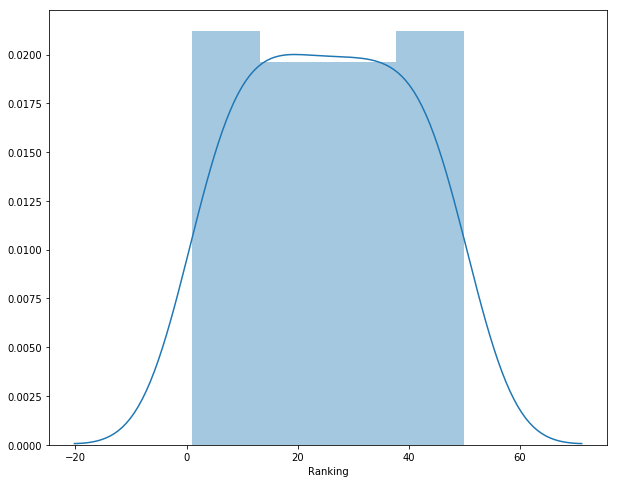

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


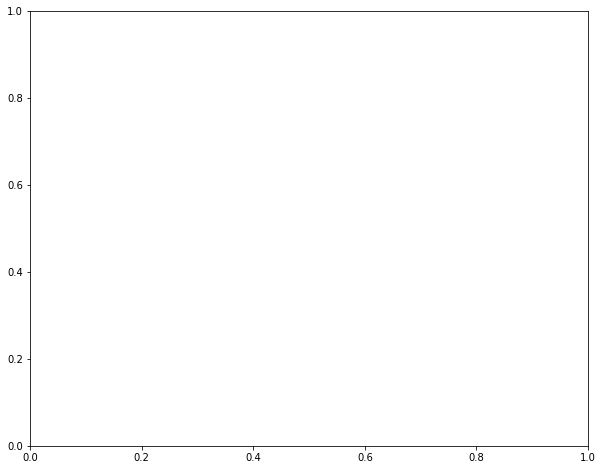

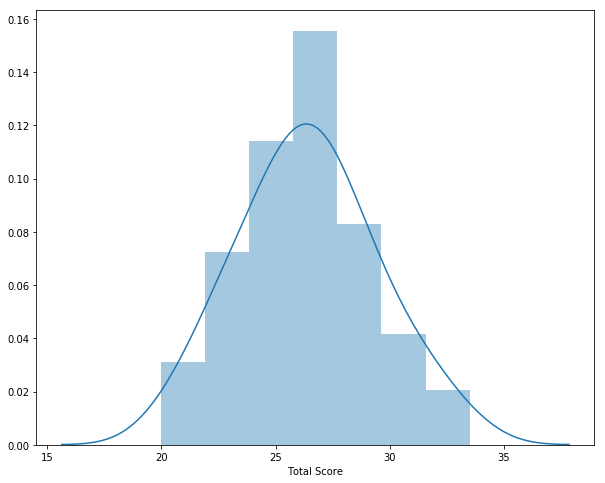

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


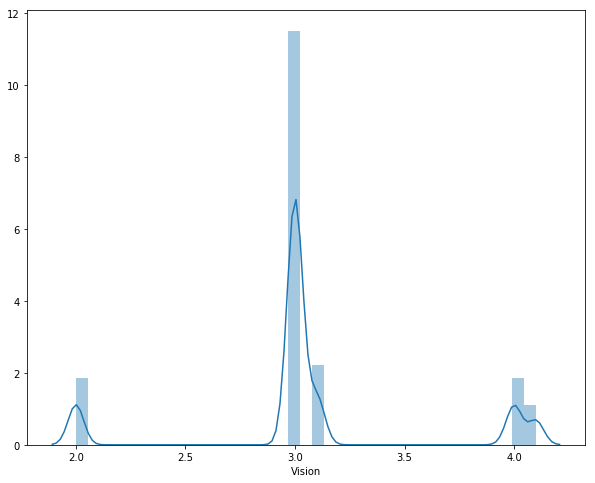

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


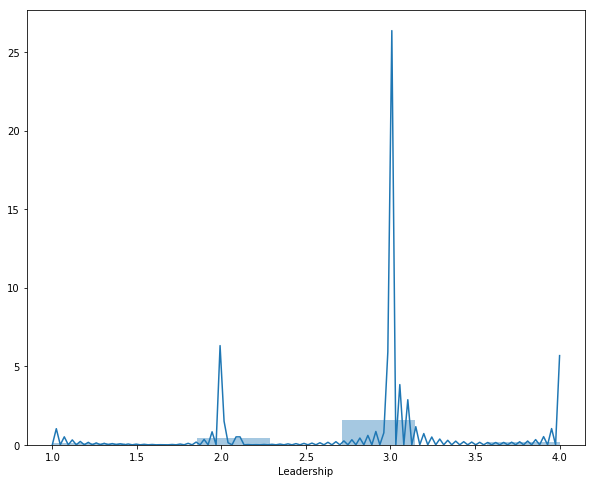

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


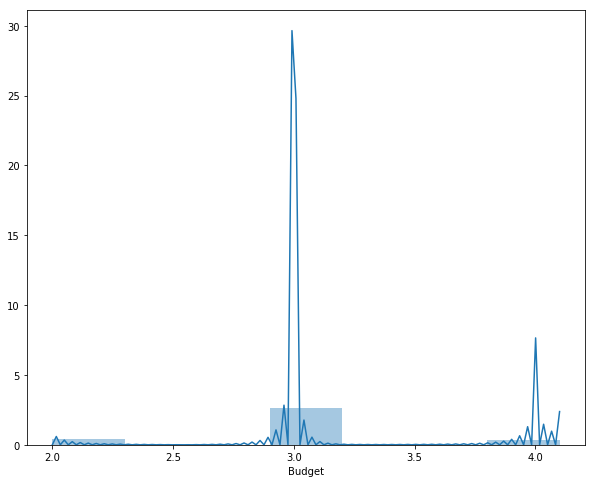

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


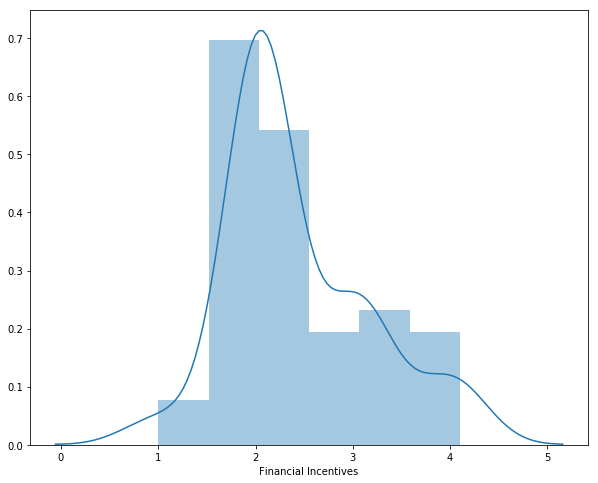

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


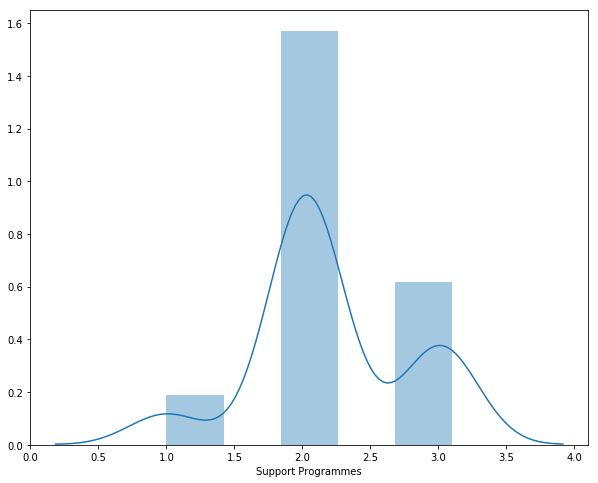

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


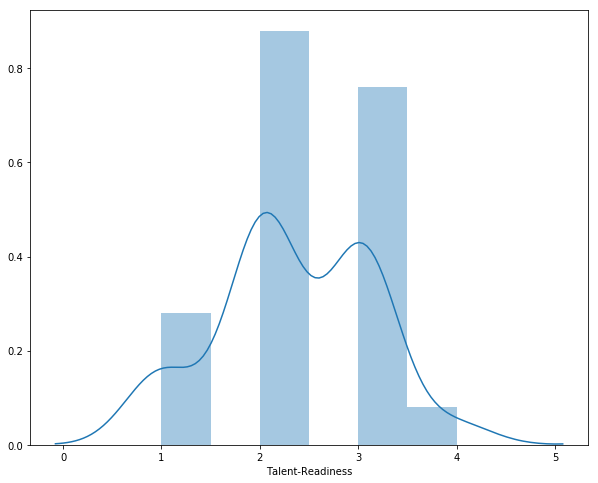

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


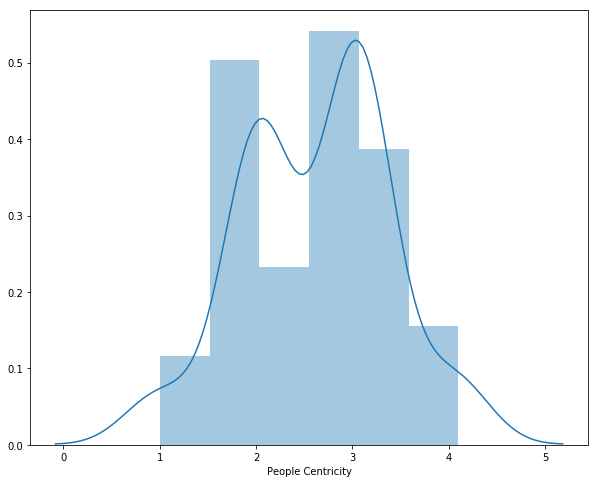

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


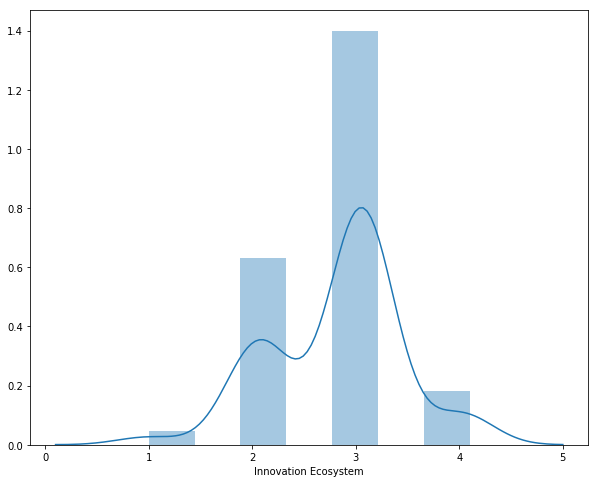

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


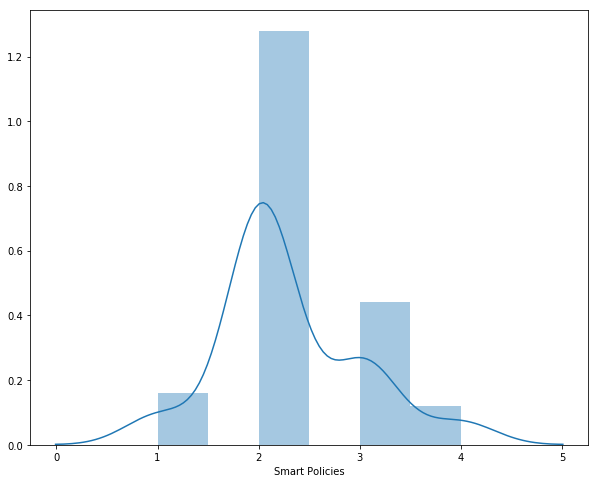

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


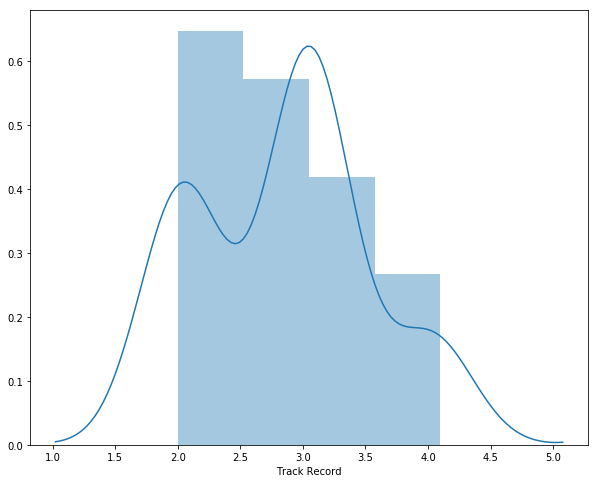

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


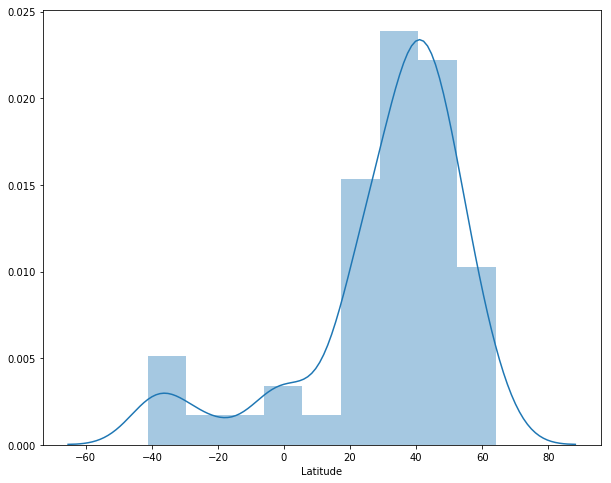

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


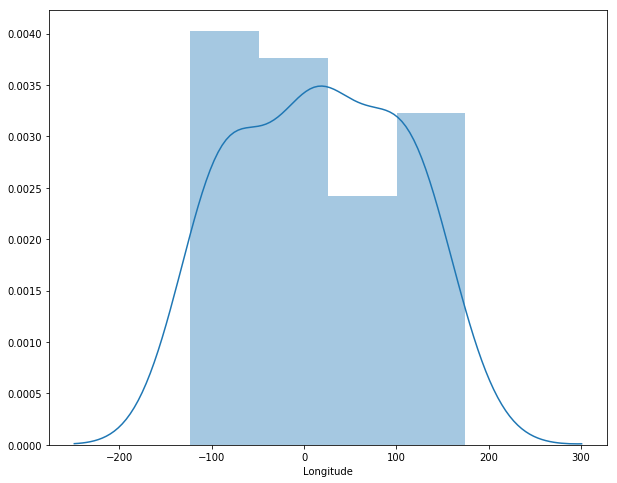

In [19]:
for i in range(len(data_table.columns)):
    try: 
        col_name = data_table.columns[i]
        col = data_table.iloc[:,i]
        plt.figure(figsize = (10,8))
        sns.distplot(col)
        plt.show()
    except:
        next
    next

In [20]:
data_table.head()

,Ranking,City,Total Score,Vision,Leadership,Budget,Financial Incentives,Support Programmes,Talent-Readiness,People Centricity,Innovation Ecosystem,Smart Policies,Track Record,Latitude,Longitude
1,1,London,33.5,3.1,4.0,3.0,4.0,3.0,3.1,3.0,4.1,3.1,3.1,51.507322,-0.127647
2,2,Singapore,32.3,3.0,4.0,3.0,4.1,3.0,3.1,2.0,3.1,4.0,3.0,1.357107,103.819499
3,3,Seoul,31.4,3.1,3.0,3.0,2.2,3.0,3.0,4.1,3.0,3.0,4.0,37.566679,126.978291
4,4,New York,31.3,3.0,3.0,3.0,3.1,3.0,3.1,3.0,4.0,2.0,4.1,40.712728,-74.006015
5,5,Helsinki,31.2,3.0,2.0,4.0,3.1,3.0,4.0,3.0,3.1,2.0,4.0,60.167410,24.942577


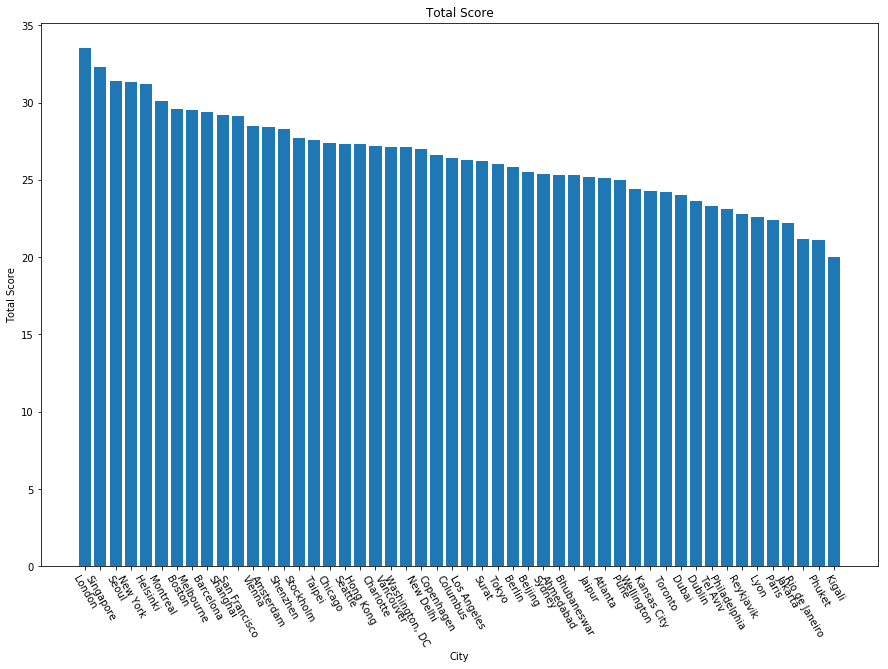

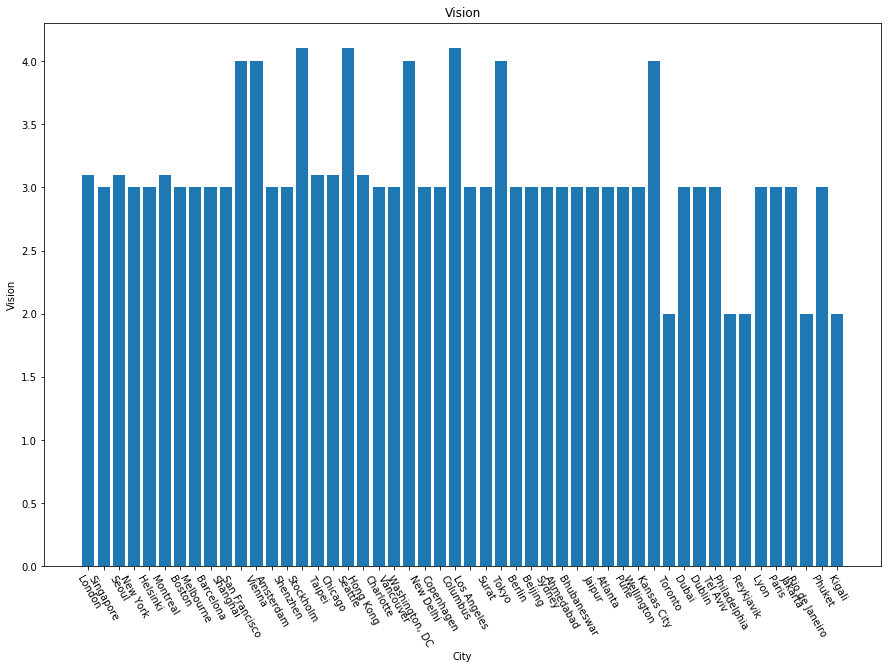

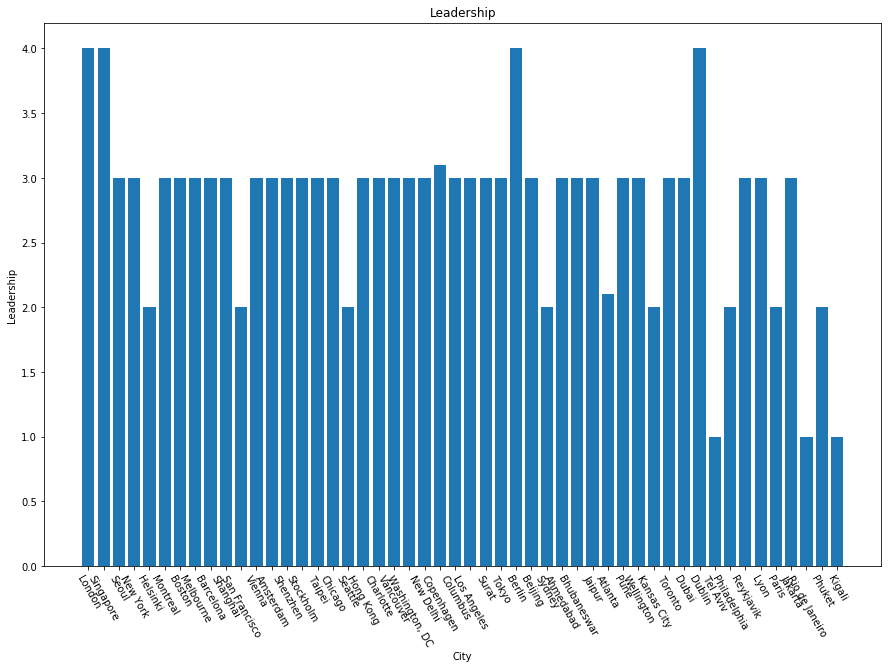

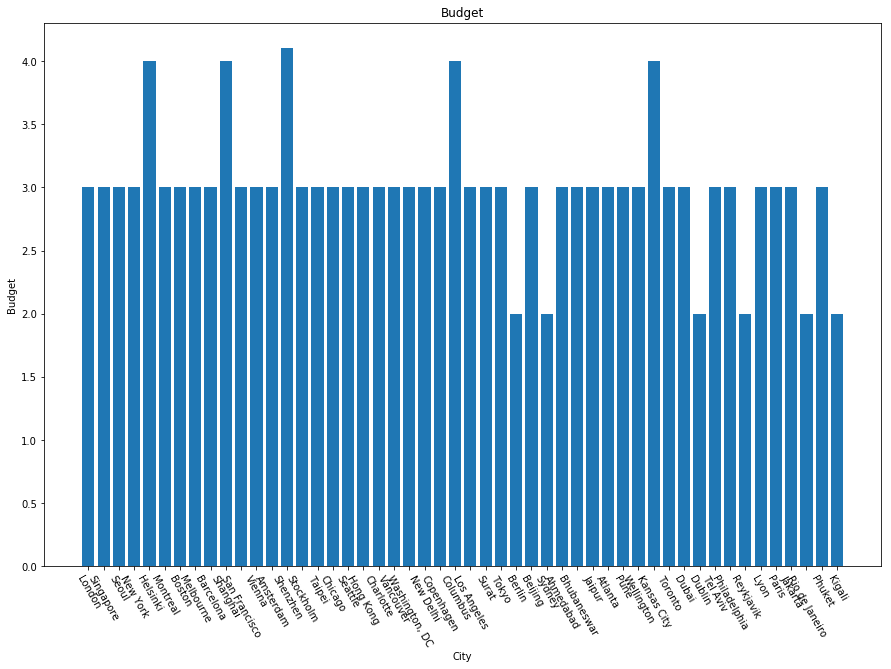

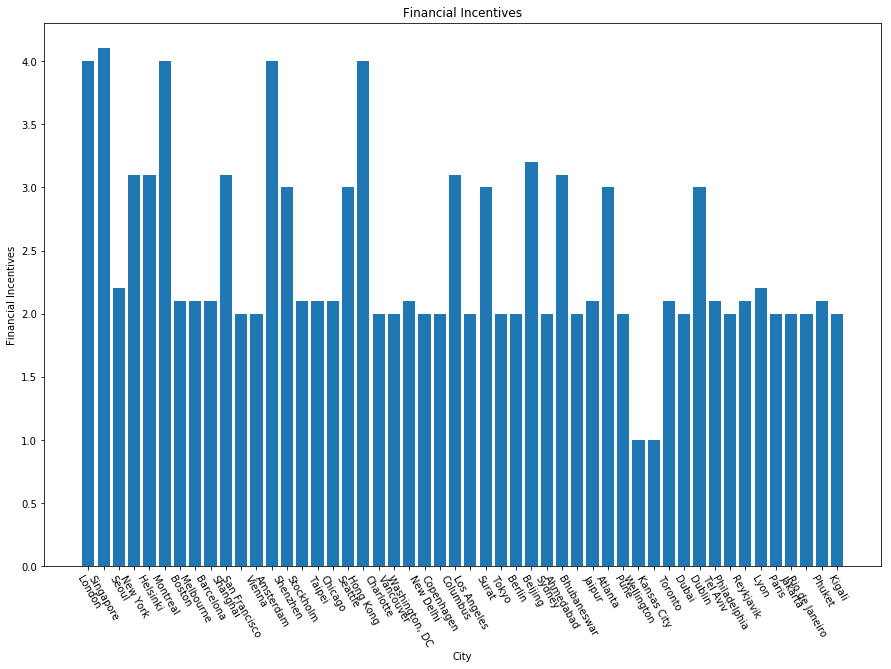

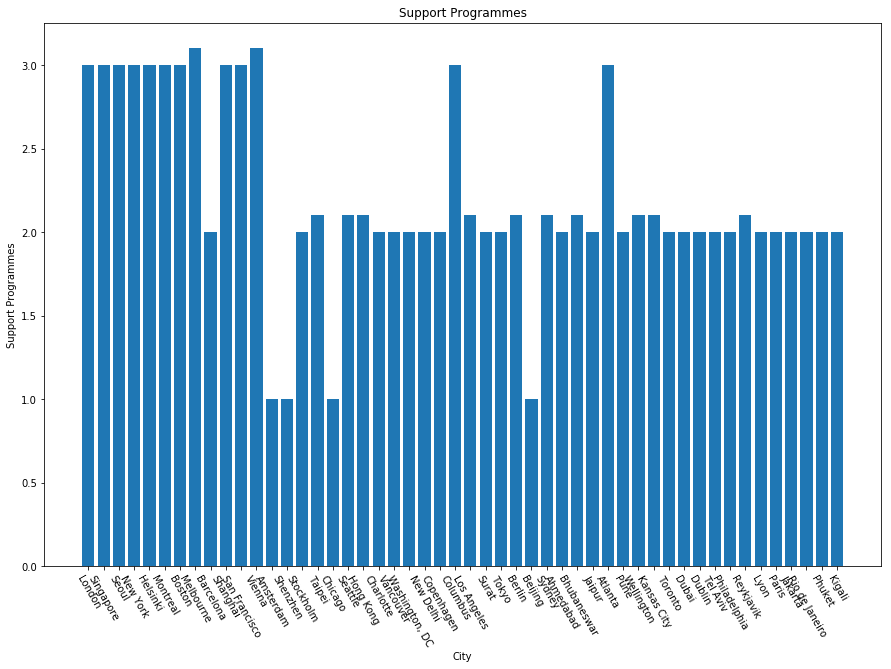

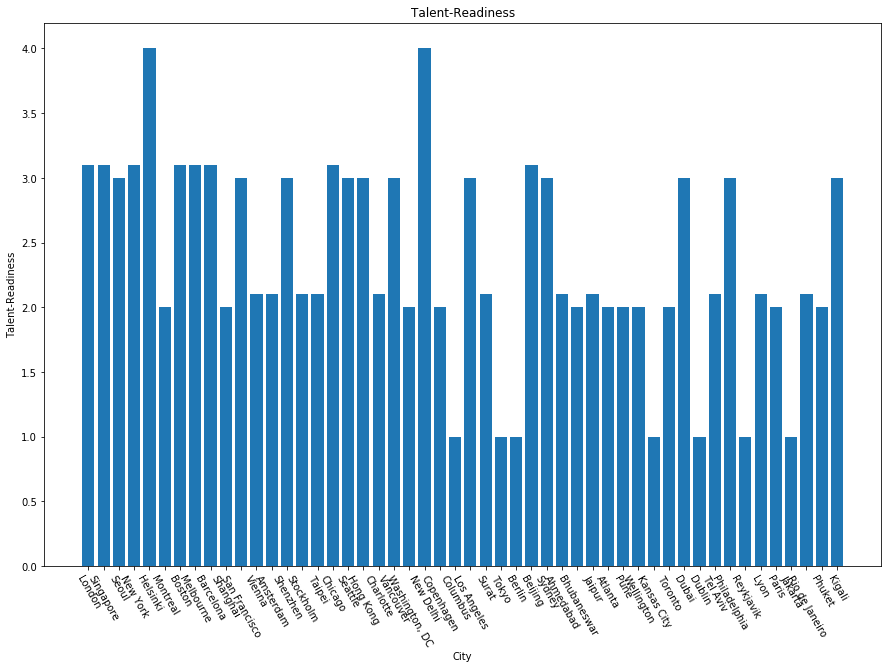

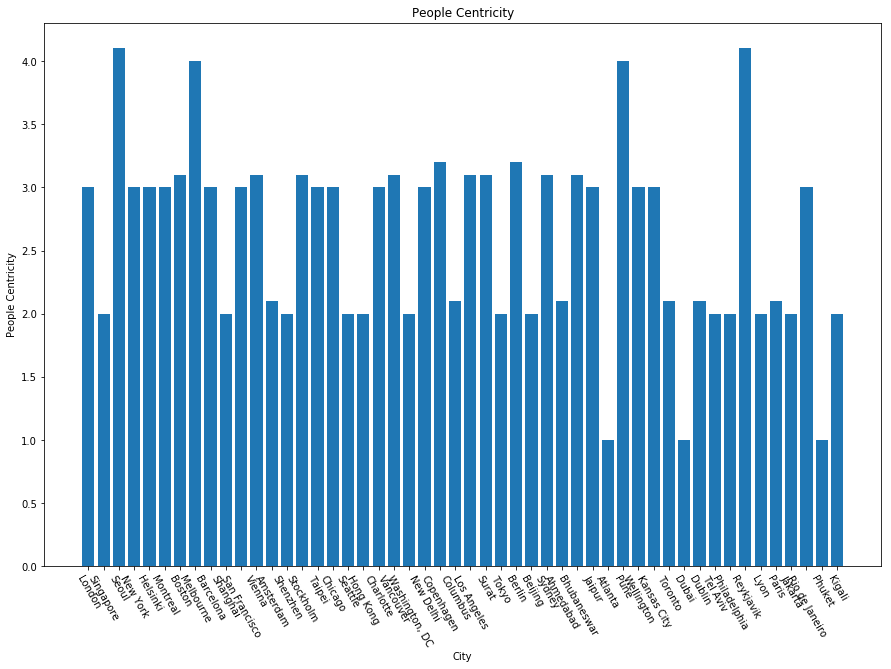

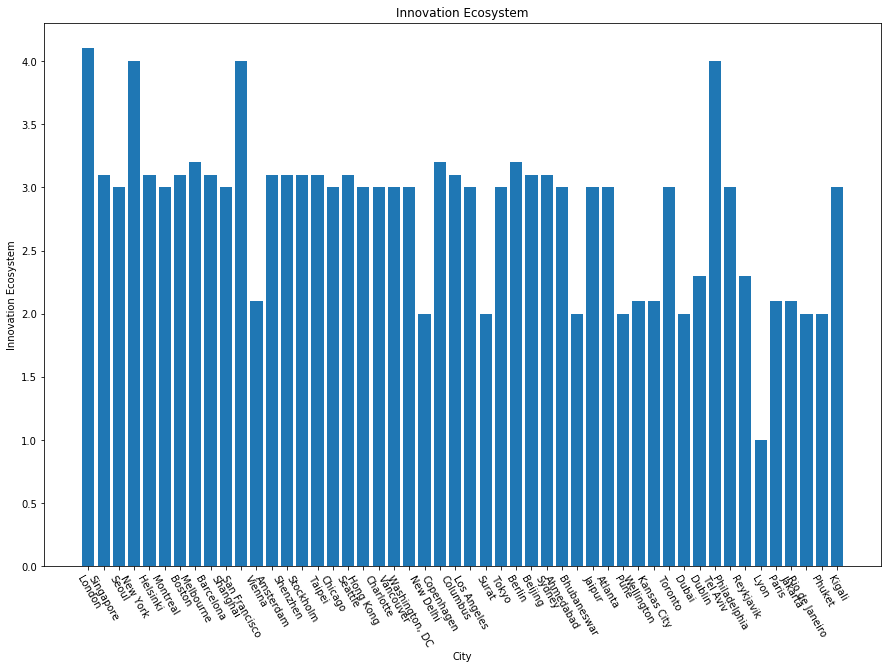

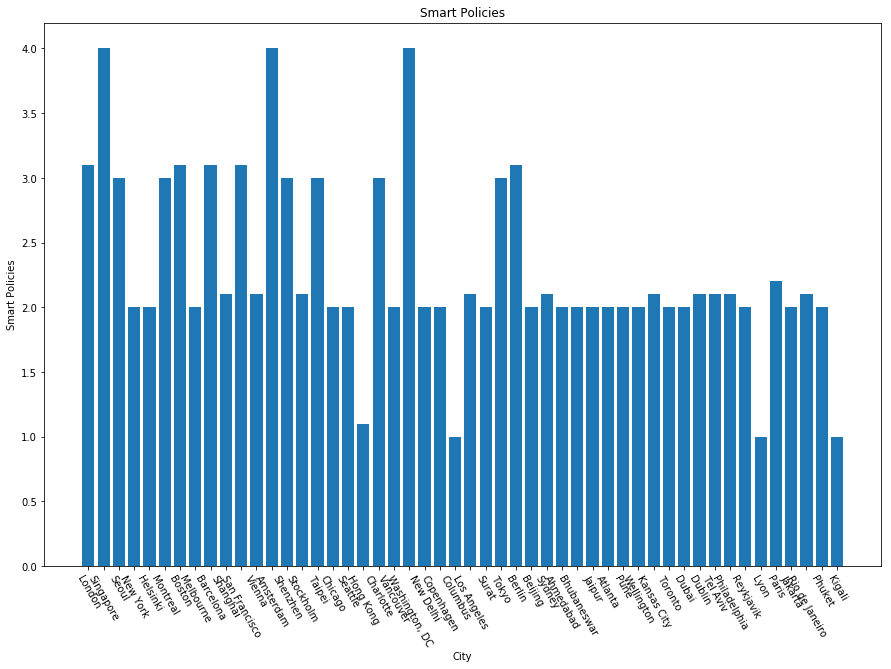

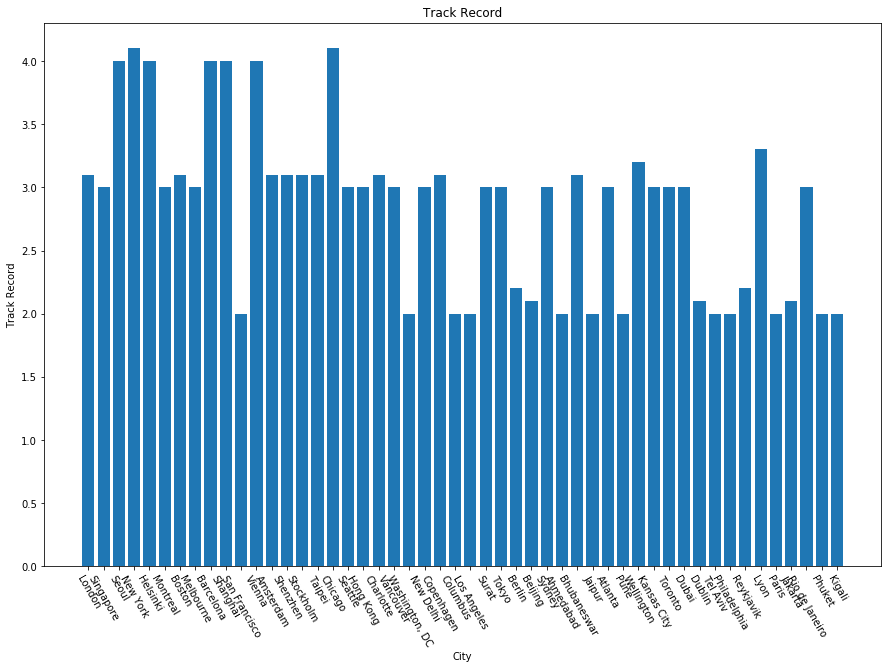

In [21]:
for i in range(2,len(data_table.columns)-2):
    try: 
        col_name = data_table.columns[i]
        col = data_table.iloc[:,i]
        plt.figure(figsize = (15,10))
        plt.bar(data_table["City"],data_table.iloc[:,i])
        plt.xlabel("City")
        plt.xticks(rotation=-60)
        plt.ylabel(col_name)
        plt.title(col_name)
        plt.show()
    except:
        next
    next


### Clustering and Analysis

In [22]:
CLIENT_ID = "OHPWNGYBB0FL3RDXDPXM4FQAGYL2HJQESEPA55EAACARKOUN" # your Foursquare ID
CLIENT_SECRET = "ZYZFOGXO3TH4SJHKUIALEKCX0K1THXXSKUCBVI414GGP3MXR" # your Foursquare Secret
VERSION = "20180604"
LIMIT = 300
radius = 5000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
    
url

'https://api.foursquare.com/v2/venues/explore?&client_id=OHPWNGYBB0FL3RDXDPXM4FQAGYL2HJQESEPA55EAACARKOUN&client_secret=ZYZFOGXO3TH4SJHKUIALEKCX0K1THXXSKUCBVI414GGP3MXR&v=20180604&ll=51.5073219,-0.1276474&radius=5000&limit=300'

In [23]:
# Get the Local Venues for the smart cities using the Foursquare API
world_venues = getNearbyVenues(names=data_table['City'],
                                   latitudes=data_table['Latitude'],
                                   longitudes=data_table['Longitude']
                                  )

London
Singapore
Seoul
New York
Helsinki
Montreal
Boston
Melbourne
Barcelona
Shanghai
San Francisco
Vienna
Amsterdam
Shenzhen
Stockholm
Taipei
Chicago
Seattle
Hong Kong
Charlotte
Vancouver
Washington, DC
New Delhi
Copenhagen
Columbus
Los Angeles
Surat
Tokyo
Berlin
Beijing
Sydney
Ahmedabad
Bhubaneswar
Jaipur
Atlanta
Pune
Wellington
Kansas City
Toronto
Dubai
Dublin
Tel Aviv
Philadelphia
Reykjavik
Lyon
Paris
Jakarta
Rio de Janeiro
Phuket
Kigali


In [25]:

# one hot encoding
world_onehot = pd.get_dummies(world_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
world_onehot['Neighborhood'] = world_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [world_onehot.columns[-1]] + list(world_onehot.columns[:-1])
world_onehot = world_onehot[fixed_columns]

world_onehot.head()

,Zoo,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Australian Restaurant,Austrian Restaurant,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Bossam/Jokbal Restaurant,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Halal Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Samba School,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Social Club,Soup Place,South American Restaurant,Southeastern Brazilian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Spea

In [26]:
#The top 5 local venues for the top 50 smart cities extracted using the Foursquare API

world_grouped = world_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 5

for hood in world_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = world_grouped[world_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ahmedabad----
         venue  freq
0       Castle  0.25
1        River  0.25
2         Park  0.25
3  Art Gallery  0.25
4          Zoo  0.00


----Amsterdam----
                  venue  freq
0                 Hotel  0.08
1                   Bar  0.08
2           Coffee Shop  0.06
3  Marijuana Dispensary  0.05
4                  Café  0.04


----Atlanta----
                  venue  freq
0        Breakfast Spot  0.11
1           Art Gallery  0.11
2  Caribbean Restaurant  0.11
3           Event Space  0.11
4          Home Service  0.11


----Barcelona----
                venue  freq
0    Tapas Restaurant  0.11
1               Plaza  0.09
2  Spanish Restaurant  0.05
3      Ice Cream Shop  0.05
4               Hotel  0.05


----Beijing----
            venue  freq
0   Historic Site  0.27
1   Metro Station  0.18
2  History Museum  0.09
3    Concert Hall  0.09
4          Castle  0.09


----Berlin----
                venue  freq
0               Hotel  0.09
1   German Restaurant  0.08
2      

In [27]:
#Find the 10 most common venues for all the locations using the FOursquare API
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = world_grouped['Neighborhood']

for ind in np.arange(world_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(world_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahmedabad,Park,Castle,River,Art Gallery,Fish & Chips Shop,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant
1,Amsterdam,Bar,Hotel,Coffee Shop,Marijuana Dispensary,Café,Clothing Store,French Restaurant,Italian Restaurant,Cocktail Bar,Restaurant
2,Atlanta,Rental Car Location,Art Gallery,Music Venue,Event Space,Home Service,College Basketball Court,Caribbean Restaurant,Breakfast Spot,American Restaurant,Falafel Restaurant
3,Barcelona,Tapas Restaurant,Plaza,Ice Cream Shop,Hotel,Spanish Restaurant,Bar,Coffee Shop,Cocktail Bar,Wine Bar,Pizza Place
4,Beijing,Historic Site,Metro Station,Park,History Museum,Scenic Lookout,Plaza,Castle,Concert Hall,Food Truck,Falafel Restaurant


In [28]:
#Clustering across 2 to 20 in an attempt to find the appropriate number of clusters
from sklearn.cluster import KMeans
world_grouped_clustering = world_grouped.drop('Neighborhood', 1)
sse = {}
# set number of clusters
for i in range(2,21):
    #kclusters = 5
    # run k-means clustering
    kmeans = KMeans(n_clusters = i, random_state=0).fit(world_grouped_clustering)
    world_grouped_clustering['Cluster'] = kmeans.labels_
    sse[i] = kmeans.inertia_

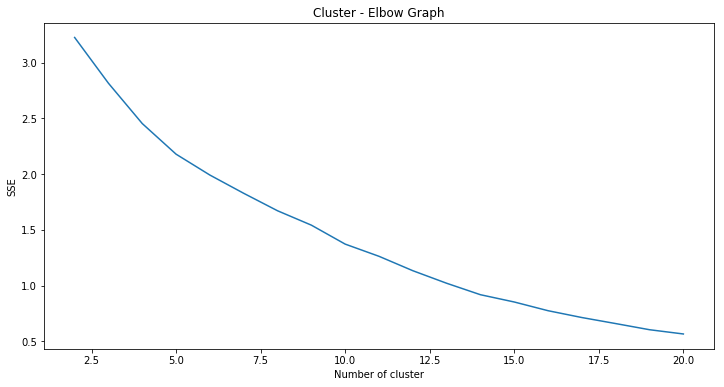

In [29]:
plt.figure(figsize = (12,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("Cluster - Elbow Graph")
plt.show()

In [30]:
kclusters = 7
    # run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(world_grouped_clustering)
world_grouped_clustering['Cluster Labels'] = kmeans.labels_
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_
kmeans.labels_[0:10] 

array([1, 1, 5, 4, 5, 1, 6, 1, 1, 1])

In [31]:
neighborhoods_venues_sorted.rename(columns = {"Neighborhood":"City"}, inplace = True)
neighborhoods_venues_sorted

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Ahmedabad,Park,Castle,River,Art Gallery,Fish & Chips Shop,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,1
1,Amsterdam,Bar,Hotel,Coffee Shop,Marijuana Dispensary,Café,Clothing Store,French Restaurant,Italian Restaurant,Cocktail Bar,Restaurant,1
2,Atlanta,Rental Car Location,Art Gallery,Music Venue,Event Space,Home Service,College Basketball Court,Caribbean Restaurant,Breakfast Spot,American Restaurant,Falafel Restaurant,5
3,Barcelona,Tapas Restaurant,Plaza,Ice Cream Shop,Hotel,Spanish Restaurant,Bar,Coffee Shop,Cocktail Bar,Wine Bar,Pizza Place,4
4,Beijing,Historic Site,Metro Station,Park,History Museum,Scenic Lookout,Plaza,Castle,Concert Hall,Food Truck,Falafel Restaurant,5
5,Berlin,Hotel,German Restaurant,Italian Restaurant,Coffee Shop,Wine Bar,Café,Vegetarian / Vegan Restaurant,Cosmetics Shop,Opera House,Theater,1
6,Bhubaneswar,Jewelry Store,Asian Restaurant,Convenience Store,Hotel,Fast Food Restaurant,Men's Store,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,6
7,Boston,Seafood Restaurant,Coffee Shop,Historic Site,Bakery,Italian Restaurant,Hotel,Sandwich Place,Bar,Falafel Restaurant,Salad Place,1
8,Charlotte,Pizza Place,Restaurant,Hotel,American Restaurant,Steakhouse,Pub,Mexican Restaurant,Seafood Restaurant,Italian Restaurant,Sandwich Place,1
9,Chicago,Coffee Shop,Sandwich Place,Donut Shop,Bookstore,Pub,Hotel,Pizza Place,Museum,Dance Studio,Fountain,1


In [32]:
final_table = pd.merge(data_table,neighborhoods_venues_sorted, on='City')
final_table.head()

,Ranking,City,Total Score,Vision,Leadership,Budget,Financial Incentives,Support Programmes,Talent-Readiness,People Centricity,Innovation Ecosystem,Smart Policies,Track Record,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,1,London,33.5,3.1,4.0,3.0,4.0,3.0,3.1,3.0,4.1,3.1,3.1,51.507322,-0.127647,Hotel,Theater,Wine Bar,Cocktail Bar,Sandwich Place,Monument / Landmark,Ice Cream Shop,Pub,Art Gallery,Plaza,1
1,2,Singapore,32.3,3.0,4.0,3.0,4.1,3.0,3.1,2.0,3.1,4.0,3.0,1.357107,103.819499,Café,Golf Course,Trail,Diner,Gym,Chinese Restaurant,Bowling Alley,Pool,Sporting Goods Shop,Food & Drink Shop,5
2,3,Seoul,31.4,3.1,3.0,3.0,2.2,3.0,3.0,4.1,3.0,3.0,4.0,37.566679,126.978291,Coffee Shop,Korean Restaurant,Historic Site,Japanese Restaurant,Hotel,Chinese Restaurant,Lounge,Café,Bookstore,Plaza,4
3,4,New York,31.3,3.0,3.0,3.0,3.1,3.0,3.1,3.0,4.0,2.0,4.1,40.712728,-74.006015,Coffee Shop,Sandwich Place,Hotel,Falafel Restaurant,Italian Restaurant,Gym,Café,Cuban Restaurant,Cocktail Bar,Plaza,1
4,5,Helsinki,31.2,3.0,2.0,4.0,3.1,3.0,4.0,3.0,3.1,2.0,4.0,60.167410,24.942577,Scandinavian Restaurant,Hotel,Bakery,Furniture / Home Store,Gym / Fitness Center,Cocktail Bar,Coffee Shop,Bar,Café,Music Venue,1


In [33]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_table['Latitude'], final_table['Longitude'], final_table['City'], final_table['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color="#202e39",
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [34]:
final_table.head()

,Ranking,City,Total Score,Vision,Leadership,Budget,Financial Incentives,Support Programmes,Talent-Readiness,People Centricity,Innovation Ecosystem,Smart Policies,Track Record,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,1,London,33.5,3.1,4.0,3.0,4.0,3.0,3.1,3.0,4.1,3.1,3.1,51.507322,-0.127647,Hotel,Theater,Wine Bar,Cocktail Bar,Sandwich Place,Monument / Landmark,Ice Cream Shop,Pub,Art Gallery,Plaza,1
1,2,Singapore,32.3,3.0,4.0,3.0,4.1,3.0,3.1,2.0,3.1,4.0,3.0,1.357107,103.819499,Café,Golf Course,Trail,Diner,Gym,Chinese Restaurant,Bowling Alley,Pool,Sporting Goods Shop,Food & Drink Shop,5
2,3,Seoul,31.4,3.1,3.0,3.0,2.2,3.0,3.0,4.1,3.0,3.0,4.0,37.566679,126.978291,Coffee Shop,Korean Restaurant,Historic Site,Japanese Restaurant,Hotel,Chinese Restaurant,Lounge,Café,Bookstore,Plaza,4
3,4,New York,31.3,3.0,3.0,3.0,3.1,3.0,3.1,3.0,4.0,2.0,4.1,40.712728,-74.006015,Coffee Shop,Sandwich Place,Hotel,Falafel Restaurant,Italian Restaurant,Gym,Café,Cuban Restaurant,Cocktail Bar,Plaza,1
4,5,Helsinki,31.2,3.0,2.0,4.0,3.1,3.0,4.0,3.0,3.1,2.0,4.0,60.167410,24.942577,Scandinavian Restaurant,Hotel,Bakery,Furniture / Home Store,Gym / Fitness Center,Cocktail Bar,Coffee Shop,Bar,Café,Music Venue,1


In [35]:
final_table.drop(["Latitude","Longitude"],axis = 1).corr()

,Ranking,Total Score,Vision,Leadership,Budget,Financial Incentives,Support Programmes,Talent-Readiness,People Centricity,Innovation Ecosystem,Smart Policies,Track Record,Cluster Labels
Ranking,1.000000,-0.980534,-0.389258,-0.396727,-0.383015,-0.475264,-0.432668,-0.468226,-0.301513,-0.548081,-0.506735,-0.580178,-0.027025
Total Score,-0.980534,1.000000,0.366850,0.454082,0.398215,0.502003,0.478516,0.455136,0.292761,0.545950,0.522494,0.557271,0.025460
Vision,-0.389258,0.366850,1.000000,0.163697,0.422825,0.016819,0.188521,-0.147123,-0.037727,0.125571,0.182306,0.093623,-0.173424
Leadership,-0.396727,0.454082,0.163697,1.000000,0.052231,0.298624,0.053681,-0.141321,0.148790,-0.010717,0.323775,0.140733,0.078180
Budget,-0.383015,0.398215,0.422825,0.052231,1.000000,0.158653,0.144273,0.129134,-0.170894,0.098628,0.010959,0.289647,-0.063283
Financial Incentives,-0.475264,0.502003,0.016819,0.298624,0.158653,1.000000,0.172643,0.202421,-0.316606,0.379132,0.200043,0.106268,0.117149
Support Programmes,-0.432668,0.478516,0.188521,0.053681,0.144273,0.172643,1.000000,0.082564,0.207126,0.220957,0.027150,0.231841,0.065429
Talent-Readiness,-0.468226,0.455136,-0.147123,-0.141321,0.129134,0.202421,0.082564,1.000000,0.070969,0.297101,0.033715,0.344220,0.092135
People Centricity,-0.301513,0.292761,-0.037727,0.148790,-0.170894,-0.316606,0.207126,0.070969,1.000000,0.029895,0.090964,0.199001,-0.080479
Innovation Ecosystem,-0.548081,0.545950,0.125571,-0.010717,0.098628,0.379132,0.220957,0.297101,0.029895,1.000000,0.345967,0.014114,-0.257447


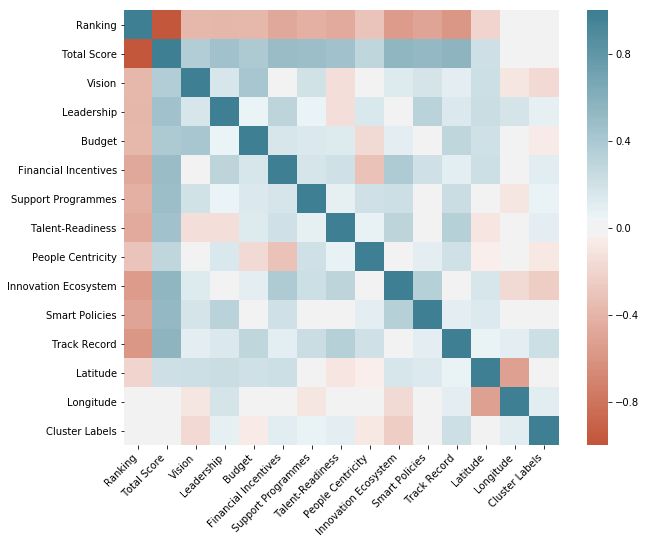

In [36]:
plt.figure(figsize = (10,8))
corr = final_table.corr() #.drop(["Latitude","Longitude"],axis = 1)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

In [37]:
final_table

,Ranking,City,Total Score,Vision,Leadership,Budget,Financial Incentives,Support Programmes,Talent-Readiness,People Centricity,Innovation Ecosystem,Smart Policies,Track Record,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,1,London,33.5,3.1,4.0,3.0,4.0,3.0,3.1,3.0,4.1,3.1,3.1,51.507322,-0.127647,Hotel,Theater,Wine Bar,Cocktail Bar,Sandwich Place,Monument / Landmark,Ice Cream Shop,Pub,Art Gallery,Plaza,1
1,2,Singapore,32.3,3.0,4.0,3.0,4.1,3.0,3.1,2.0,3.1,4.0,3.0,1.357107,103.819499,Café,Golf Course,Trail,Diner,Gym,Chinese Restaurant,Bowling Alley,Pool,Sporting Goods Shop,Food & Drink Shop,5
2,3,Seoul,31.4,3.1,3.0,3.0,2.2,3.0,3.0,4.1,3.0,3.0,4.0,37.566679,126.978291,Coffee Shop,Korean Restaurant,Historic Site,Japanese Restaurant,Hotel,Chinese Restaurant,Lounge,Café,Bookstore,Plaza,4
3,4,New York,31.3,3.0,3.0,3.0,3.1,3.0,3.1,3.0,4.0,2.0,4.1,40.712728,-74.006015,Coffee Shop,Sandwich Place,Hotel,Falafel Restaurant,Italian Restaurant,Gym,Café,Cuban Restaurant,Cocktail Bar,Plaza,1
4,5,Helsinki,31.2,3.0,2.0,4.0,3.1,3.0,4.0,3.0,3.1,2.0,4.0,60.167410,24.942577,Scandinavian Restaurant,Hotel,Bakery,Furniture / Home Store,Gym / Fitness Center,Cocktail Bar,Coffee Shop,Bar,Café,Music Venue,1
5,6,Montreal,30.1,3.1,3.0,3.0,4.0,3.0,2.0,3.0,3.0,3.0,3.0,45.497216,-73.610364,Convenience Store,Hobby Shop,Residential Building (Apartment / Condo),Business Service,Bus Station,Furniture / Home Store,Indonesian Restaurant,Fountain,Event Space,Exhibit,3
6,7,Boston,29.6,3.0,3.0,3.0,2.1,3.0,3.1,3.1,3.1,3.1,3.1,42.360253,-71.058291,Seafood Restaurant,Coffee Shop,Historic Site,Bakery,Italian Restaurant,Hotel,Sandwich Place,Bar,Falafel Restaurant,Salad Place,1
7,8,Melbourne,29.5,3.0,3.0,3.0,2.1,3.1,3.1,4.0,3.2,2.0,3.0,-37.814218,144.963161,Café,Coffee Shop,Bar,Cocktail Bar,Dessert Shop,Shopping Mall,Italian Restaurant,Toy / Game Store,Burger Joint,Movie Theater,0
8,9,Barcelona,29.4,3.0,3.0,3.0,2.1,2.0,3.1,3.0,3.1,3.1,4.0,41.382894,2.177432,Tapas Restaurant,Plaza,Ice Cream Shop,Hotel,Spanish Restaurant,Bar,Coffee Shop,Cocktail Bar,Wine Bar,Pizza Place,4
9,10,Shanghai,29.2,3.0,3.0,4.0,3.1,3.0,2.0,2.0,3.0,2.1,4.0,31.225299,121.489050,Coffee Shop,Fast Food Restaurant,Dumpling Restaurant,Historic Site,Market,Shopping Mall,Garden,Food Court,Department Store,Buddhist Temple,6


In [38]:
final_table["1st Most Common Venue"].value_counts()

Coffee Shop                7
Café                       5
Hotel                      5
Park                       4
Bar                        3
Historic Site              3
French Restaurant          2
Garden                     2
Scandinavian Restaurant    2
Pub                        1
Seafood Restaurant         1
Department Store           1
Tapas Restaurant           1
Rental Car Location        1
Jewelry Store              1
Theater                    1
Pizza Place                1
Cocktail Bar               1
Convenience Store          1
Arts & Crafts Store        1
Bakery                     1
Museum                     1
Fast Food Restaurant       1
Sandwich Place             1
Name: 1st Most Common Venue, dtype: int64

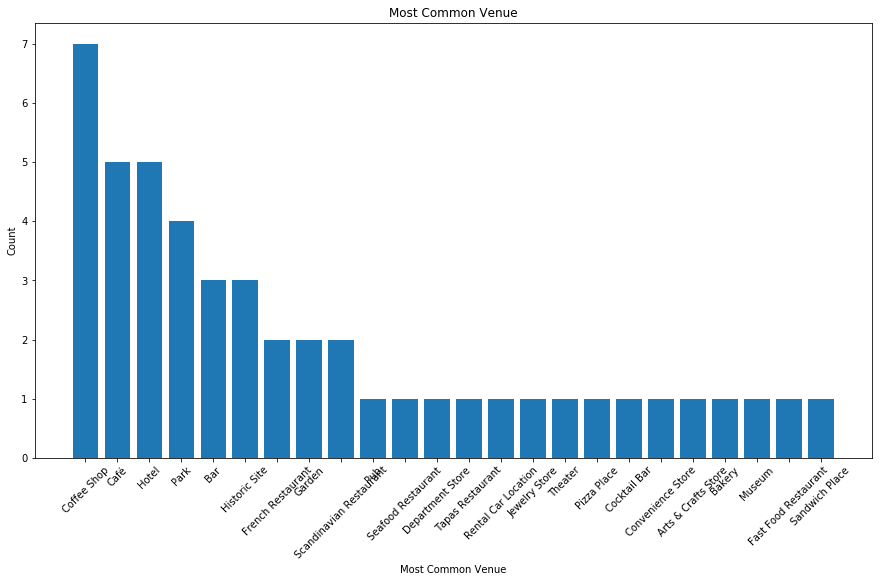

In [51]:
venue_count = pd.DataFrame(final_table["1st Most Common Venue"].value_counts())
plt.figure(figsize = (15,8))
plt.bar(venue_count.index,venue_count["1st Most Common Venue"])
plt.xlabel("Most Common Venue")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.title("Most Common Venue")
plt.show()

In [63]:
final_table
final_table.to_csv("C:\\Users\\Bhaskar Rao\\git-projects\\file2.csv", index = True)

In [56]:
tab = final_table.pivot_table(index = "City", columns = "Cluster Labels",values = "Ranking", aggfunc = "nunique")
tab

Cluster Labels,0,1,2,3,4,5,6
City,,,,,,,
Ahmedabad,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Amsterdam,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Atlanta,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Barcelona,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Beijing,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Berlin,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Bhubaneswar,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Boston,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Charlotte,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [60]:
tab.to_csv("C:\\Users\\Bhaskar Rao\\git-projects\\file.csv", index = True)